<p align="center">
<img src="http://wandb.me/logo-im-png" width="800" alt="Weights & Biases" />
</p>

# 🪐 Operation REBOOT: Mission Start

Welcome, **Neural Architect**. The ship's AI core is down. Your job: fine-tune a foundational model with astronomical data to restore its deep space knowledge. This notebook will walk you through all the necessary steps and even help you test and evaluate your final model. 

**Your mission:**
- Load and adjust the data 
- Configure training arguments
- Launch training and monitor with **Weights & Biases (W&B)**
- Test and evaluate your fine-tuned model

All systems go. Let's bring this vessel back online.

#### Install and Import the required libraries

In [ ]:
!pip install transformers datasets accelerate wandb trl huggingface_hub hf-transfer bitsandbytes peft torchvision pandas numpy --force-reinstall -qqq

In [ ]:
import wandb

import json
import math
import random
from pathlib import Path
from datetime import datetime
import pytz
import random


import torch
import torchvision
import pandas as pd
from datasets import Dataset
from transformers import TrainingArguments, Trainer

In [ ]:
from utilities.helpers import * #helper functions used throughout our notebook. Take a peek here while your training job runs.

## 🔌 Connect Neural Telemetry (W&B Setup)

In [ ]:
# Wait to be prompted to authenticate your wandb account 
# You can find your API key in your browser here: https://wandb.ai/authorize
# Paste an API key from your profile and hit enter:
wandb.login()

In [ ]:
WANDB_PROJECT_NAME = "Astros-FT-Workshop"
WANDB_ENTITY = "FT-Testing" #Set your W&B Entity (check quest page)
WORKSHOP_TEAM_NAME = "Wandb_Crew" #Set to your Workshop Team Name (check quest page)

## 🧪 Dataset Control Room
Adjust the dataset and prepare the astronomical data for training.

## 🌎 Initialize Experiment, Read Data, Split Data ☄️

In this section, we:

* Retrieve the Astros Dataset from [W&B Registry FC_FT_Workshop_Dataset collection](https://wandb.ai/orgs/FullyConnected-2025-Workshops/registry/dataset?selectionPath=fullyconnected-2025-workshops%2Fwandb-registry-dataset%2FFC_FT_Workshop_Dataset&view=versions) 
* Load the Astro Dataset containing universe-related Q&A data.
* Create prompts from the question/answer pairs & load into a pandas dataframe

✅ All the heavy lifting is done here automatically — no manual setup needed

#### Let's prepare our training dataset

In [ ]:
local_tz = pytz.timezone("US/Pacific")
timestamp = datetime.now(local_tz).strftime("%H%M")

# Step 1: Initialize W&B run and download dataset
print("Step 1: Downloading dataset from Weights & Biases...")
run = wandb.init(entity=WANDB_ENTITY,
                 project=WANDB_PROJECT_NAME,
                 id=f"Operation_Reboot_{timestamp}",
                 resume="allow")

# Download the dataset artifact
artifact = run.use_artifact('wandb-registry-dataset/FC_FT_Workshop_Dataset:v5', type='dataset')
dataset_dir = artifact.download()
print("✅ Dataset downloaded successfully!")

# Step 2: Load and prepare datasets
df_train, training_dataset = load_and_prepare_dataset(dataset_dir, "astro_dataset_train.jsonl", "training") #look at the helper fuctions if you're interested in how we prepare the data

# Print dataset statistics
print("\nDataset Statistics:")
print(f"Training examples: {len(df_train)}")
print("\nExample prompt format:")
print(df_train['text'].iloc[0])

### 🚩 Checkpoint 🚩

You've reached your first checkpoint. Follow the link above to see your run in the W&B environment. Grab the URL of the run and submit it on the quest page to get points

### 🌌 Dataset Loaded Successfully!

At this point, we've:
* Retrieved the Astros Dataset artifact
* Loaded it into a pandas DataFrame
* Created prompt-style text for fine-tuning

✨ Feel free to pause and explore the data before moving forward!

Exploring the dataset can help you:

* Understand the kinds of questions and answers the model will learn from
* Check for any strange patterns, formatting issues, or interesting insights
* Discover Easter Eggs

🛡️ We've added soft error handling while loading, so if you accidentally modify the dataset file, you'll be warned if any loading issues happen.

👉 Quick Tip: You don't need to modify the dataset to proceed, but if you want to explore, you can run things like:

```
print(df_train.sample(5))
print(df_train['question'].apply(len).describe())
print(df_train['answer'].apply(len).describe())
```

When you're ready, move on to loading the model and tokenizing the dataset!

## 🧠 Model Vault: Download & Configure the Base Model

## 🚀 Load Pretrained Model and Prepare Dataset for Fine-Tuning 🌠
In this section, we:

* Retrieve the Model to Finetune from [W&B Registry FC_FT_Workshop_Model](https://wandb.ai/orgs/FullyConnected-2025-Workshops/registry/model?selectionPath=fullyconnected-2025-workshops%2Fwandb-registry-model%2FFC_FT_Workshop_Model&view=versions) 
* Select a pretrained language model.
* Split the dataset into training and validation sets.
* Finally, load the model and tokenizers to prepare for finetuning. 

✅ All the setup for model loading, tokenization, and data splitting is handled for you — no manual steps required!

### Select Model
You will be prompted to select one of the following models

*   Option 1: [falcon-rw-1b](https://huggingface.co/tiiuae/falcon-rw-1b)
*   Option 2: [TinyLlama](https://huggingface.co/TinyLlama/TinyLlama-1.1B-Chat-v1.0)


In [ ]:
model_name, version = get_model_from_wandb(WANDB_ENTITY, WANDB_PROJECT_NAME, run_id=f"Operation_Reboot_{timestamp}")



Next, we'll make a few adjustments to ensure the model handles padding correctly,
and then prepare our dataset for training by tokenizing the input prompts.


## 🔄 Tokenize & Split: Format Data for Finetuning

#### Load the datasets

You can modify how our training data is passed to our training script to finetune the model. Make sure to analyze the data so you can select an appropriate **Sample Size** and  **Train/Test split** for the finetuning process.


In [ ]:
sample_size = 100 # choose between 100 and 1600 samples to train. More samples can improve your model, but increase training time
train_test_split = 0.1 # choose a float value between 0 and 1

training_sample = training_dataset.shuffle(seed=42).select(range(sample_size)) 

#### Load the model, tokenizers, and tokenize the dataset

In [ ]:
model, tokenizer, model_name = load_model_and_tokenizer(model_name, version)
train_dataset, eval_dataset = tokenized_train_test(training_dataset, train_test_split, tokenizer)

## ⚙️ Training Command Center
Set training arguments to guide your model's learning trajectory.

## 🛰️ Training Arguments (Where You Fine-Tune Settings) 🌙

This is where you'll do most of your experimentation! 🎯

The `TrainingArguments` object controls how your model is fine-tuned, including:

* Batch size
* Number of epochs
* Learning rate
* Warmup steps
* Mixed precision (fp16) for faster training
* Checkpoint saving
* Reporting to Weights & Biases and more......

You can modify the hyperparameters here to see how different settings impact model performance.

####  💡 Create your own Fine-Tuning Strategy:

🔧 learning_rate  
Controls how fast the model learns. Use 1e-4 to 2e-3; lower for full finetuning, higher for qlora.  
Interacts with warmup_ratio and lr_scheduler_type — higher learning rates need more warmup.

⚙️ optim  
Selects optimizer; 'adamw_torch' is fused and faster on GPU.  
Combine with a good learning rate and warmup for stable convergence.

📈 num_train_epochs  
Number of times the model sees the full dataset. Start with 2–5.  
Runs with more epochs will take longer and need more compute. 

📊 gradient_accumulation_steps  
Simulates large batch sizes by accumulating gradients across steps.  
We will use large batch sizes. Keep this low to speed up training.

📦 per_device_train_batch_size  
Controls the number of samples processed per gpu per step.  
Larger batch = more stable gradients but more memory usage.
Our GPU is not memory-constrained, keep this high.

🔥 warmup_ratio  
Gradually ramps up learning rate to avoid early divergence.  
Set between 0.05–0.1, especially important with higher learning rates.

📉 lr_scheduler_type  
Controls how learning rate decays. 'cosine' gives smoother transitions, 'linear' is simpler.  
Works in tandem with warmup_ratio and total training steps.

⚡ fp16 / bf16  
Enables mixed-precision training for faster speed and lower memory use.  
Use bf16 on newer GPUs (A100+, H100), fp16 works best for our A10G GPU.

🧠 gradient_checkpointing  
Reduces memory by recomputing activations during backward pass.  
Useful for large models on smaller gpus; increases compute cost.

💾 save_strategy / save_total_limit  
Determines when and how often to save models. 'epoch' is safer for llms.  
Limit total checkpoints (e.g., 5) to save disk space.

🧪 eval_strategy  
Controls evaluation frequency. Use 'epoch' for stability, 'steps' for faster feedback.  
Combine with logging_steps for clear model monitoring.

📏 group_by_length  
Batches examples of similar length together.  
Speeds up training when working with variable-length sequences.

📐 auto_find_batch_size  
Automatically adjusts batch size to prevent OOM errors.  

📝 logging_steps  
How often to log metrics like loss and learning rate.  
Use 10–50 to balance visibility with log noise.

📊 report_to  
Set to 'wandb' to enable experiment tracking, charts, and comparisons.  
This will ensure we can capture our training and system metrics.

🏆 metric_for_best_model  
Automatically selects the best checkpoint based on our validation metric.  

🧱 weight_decay  
Regularization to prevent overfitting. Typical values: 0.01 to 0.1.  
Use with higher learning rates or longer training to avoid memorization.

🧹 remove_unused_columns  
Cleans up unused columns from the dataset during training.  

🔄 dataloader_num_workers / dataloader_pin_memory  
Set workers to 4–16 for best throughput. 

🏷️ label_names  
Used to identify which label columns to include in loss computation.  

*Ask our team for help if you have questions about any parameters listed here*

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    run_name=f"fine-tuning-{model_name}-qlora",
    output_dir="./results",
    num_train_epochs=1, #start with 2 and go up to 10 epochs for better results
    per_device_train_batch_size=42,
    per_device_eval_batch_size=4,
    dataloader_num_workers=16,
    gradient_accumulation_steps=1,
    warmup_ratio=0.1,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    do_train=True,
    do_eval=True,
    fp16=True,
    bf16=False,
    gradient_checkpointing=False, #Choose to store the full forward-pass activations in GPU RAM
    group_by_length=True,
    report_to=["wandb"],
    remove_unused_columns=True,
    dataloader_pin_memory=True,
    optim="adamw_torch", #See https://huggingface.co/docs/transformers/v4.51.3/en/perf_train_gpu_one#optimizers
    learning_rate=2e-3,
    lr_scheduler_type="cosine", # See https://huggingface.co/docs/transformers/en/main_classes/optimizer_schedules#transformers.SchedulerType
    auto_find_batch_size=False,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=5,
    load_best_model_at_end=False,
    metric_for_best_model="eval_loss",
    logging_strategy="steps",
    label_names=["labels"],
)

## 🛰️ Engage Training Tracker
Launch the model and track training live with W&B.

## 🔭 Initialize Trainer, Train, and Save 🌎

In this final section:

* We initialize the Trainer with:
  * The model
  * tokenizer
  * The data
  * The training arguments

* We start training by calling trainer.train().
* We save the fine-tuned adapter and tokenizer locally.
* We finish the W&B run to close the logging cleanly.

🧠 Reminder: After training finishes, we will test and evaluate the fine-tuned model in this notebook.

🚨 Training Ahead: Be ready for 10-15 min runtimes with the default configs!


In [ ]:
#Configure model for training
model.config.use_cache = False  # Disable cache during training

# Set label names for PEFT model
model.config.label_names = ["labels"]

# Initialize trainer with modified configuration
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=DataCollatorForLanguageModeling(
        tokenizer=tokenizer,
        mlm=False,
        pad_to_multiple_of=8  # Add padding to multiple of 8 for better performance
    ),
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# Enable gradient checkpointing with the new format
if hasattr(model, "enable_input_require_grads"):
    model.enable_input_require_grads()

## ⚙ Now we kick off the training process ⚙

In [ ]:
#Train
run = wandb.init(entity=WANDB_ENTITY,
                 project=WANDB_PROJECT_NAME,
                 id=f"Operation_Reboot_{timestamp}", 
                 resume="allow")
train_output = trainer.train()

## 💾 Save & Upload
Preserve your fine-tuned model as a W&B artifact.

We will now save this model to W&B. You will need the `Full Artifact Name` from W&B to get points for completing the finetuning section.

Tracking your model in W&B can be really helpful:

- You can now share this model with your team and beyond
- W&B creates a lineage map of your model so you can see the full model lifecycle: dataset->training->final state

In [ ]:
#Saving and uploading best model - working draft
trainer.save_model(f"./best_model/{type(model.base_model.model).__name__}")
tokenizer.save_pretrained(f"./best_model/{type(model.base_model.model).__name__}")

run = wandb.init(entity=WANDB_ENTITY,
                 project=WANDB_PROJECT_NAME,
                 id=f"Operation_Reboot_{timestamp}",
                 resume="allow")

artifact = wandb.Artifact(
    name=f"{WORKSHOP_TEAM_NAME}-ft-best-model-{type(model.base_model.model).__name__}",
    type="model",
    description="""Best FineTuned model from the Astros-FT-Workshop."""
)

artifact.add_dir(local_path="./best_model")

logged_artifact = run.log_artifact(artifact)

run.link_artifact(
  artifact=logged_artifact,
  target_path="wandb-registry-model/FC_FT_Workshop_FineTuned_Models"
)

run.finish()

### 🚩 Checkpoint 🚩

You've reached your second checkpoint. 

Navigate to wandb by clicking the link next to `View project at:` above and then click on the yellow Weights & Biases logo on the top left of the page.  
On the left panel, under **Applications** click Registry. Find your artifact and retrieve the `Full Artifact Name` that you can submit on the quest page.
Your team may submit up to 5 unique adapters to get points. 

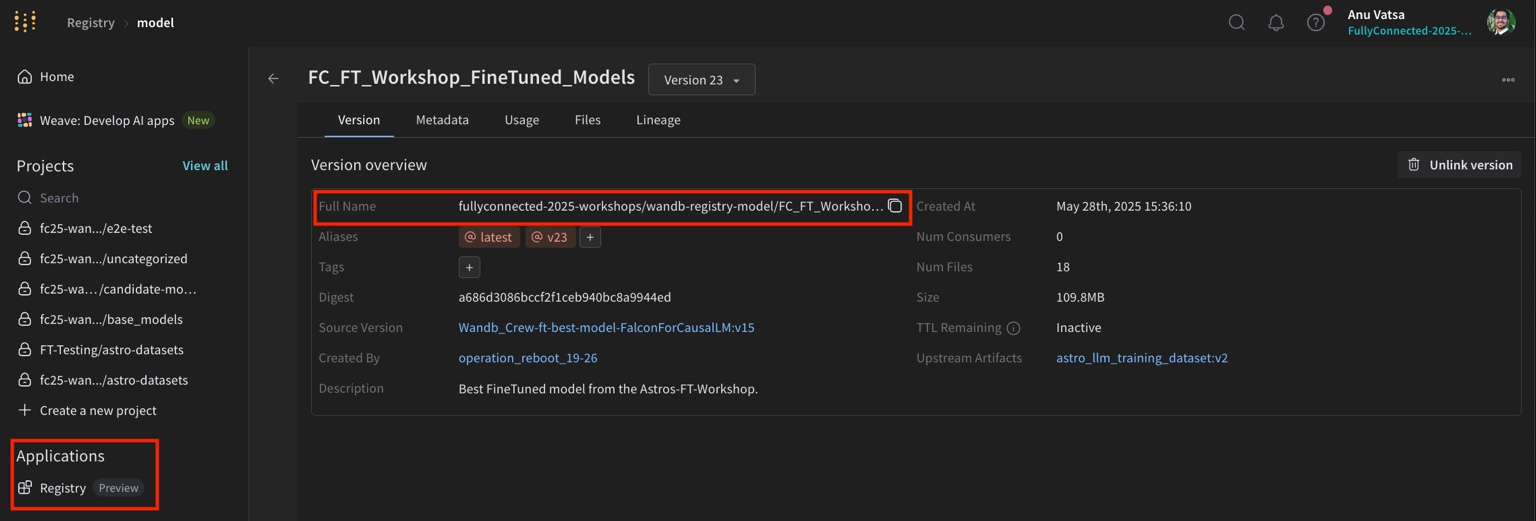

## ✅ Mission Checkpoint: Model Finetuned

Congratulations, Architect! You've:
- Loaded and prepped your training dataset ✅
- Configured a foundational model ✅
- Finetuned it with parameter-efficient methods ✅
- Logged your training runs and saved the final model to Weights & Biases ✅

Your model is now part of your mission's neural infrastructure.

Next, we prepare to test and evaluate. But first, a quick system check...

## 🧰 Systems Maintenance Bay: Utilities

Before testing, it's wise to flush memory and check your hardware status. Use these utilities to prepare the environment.

Just like a good engineer, make sure the ship's neural bays are cleared and ready.

## Utilities 🧰

In [ ]:
# -- Flush out GPU memory - when required - may require restarting the notebook
import gc, torch

try:
    del trainer
except: print("cannot release memory")
try:
    del model
except: print("cannot release memory")
try:
    del tokenizer
except: print("cannot release memory")

gc.collect()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

wandb.finish()

Let's check on our GPU.

In [ ]:
!nvidia-smi

## 🧪 Testing the Neural Core

Now that your model is trained and uploaded, it’s time to test your new candidate neural core.

You’ll load the fine-tuned model and run test prompts to ensure it responds with precision and depth, critical for deep-space operations.

We’ve equipped you with a call function wrapped in `Weave`, our GenAI interface and telemetry layer.

## 🔧 Testing our model with the adapter🪛

Let's start by creating some helper functions to load and call the model we just trained.

Since we created an adapter during the finetuning process, our load model function loads the original model along with our adapter using PEFT.

## 🛰️ Introducing Weave: Your AI Telemetry and Evaluation Suite

**Weave** is Weights & Biases’ next-gen platform for tracking, evaluating, and visualizing GenAI applications.

You'll use Weave to:
- Log and score model generations
- Run structured evaluations on Q&A performance
- Compare outputs with reference answers

This enables you to **quantitatively assess** how mission-ready your model is.

Let’s initialize Weave and plug it into your finetuned system.

In [ ]:
!pip install weave "weave[scorers]" -q

In [ ]:
import weave
weave.init(f"{WANDB_ENTITY}/{WANDB_PROJECT_NAME}")

## Calling our Local Finetuned Model

### Load model

We will now pass the finetuned adapter and the base model to be loaded as one entity that we can use. This model should be able to navigate complex astronomical questions from our evaluation dataset.

In [ ]:
base_model_dir = "./models/falcon-rw-1b_v0" # Path to base model - modify accordingly to fine_tuned_model/<TinyLlama_v1 or falcon-rw-1b_v0>
adapter_dir = "./best_model/FalconForCausalLM" #add path to adapter dir

tokenizer, model = load_finetuned_model(adapter_dir, base_model_dir)

#### Generating respones from the model

This function acts as our interface with the model for text-based interactions. 

In [ ]:
@weave.op()
def call_model(question: str) -> str:
    """Generate an answer from your Local LLM given a prompt."""

    system_prompt = "You are an expert in astrophysics. Please provide a concise and truthful answer to the following question:"
    prompt = system_prompt + "\n\n" + question + "\nAnswer:"

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    with torch.no_grad():
        output = model.generate(**inputs, max_new_tokens=256, do_sample=False, no_repeat_ngram_size=3, repetition_penalty=1.2, eos_token_id=tokenizer.eos_token_id, pad_token_id=model.config.eos_token_id)
    return tokenizer.decode(output[0], skip_special_tokens=True).replace(prompt, '').strip()

## 📊 Final Check: Evaluation Protocols

Your neural core is active, but is it mission-grade?

Use this section to:
- Load an evaluation dataset
- Score model responses using embedding similarity
- Track performance with W&B + Weave

**Evaluation is critical** before deployment—it ensures your model’s reasoning is aligned with mission parameters.

In this task, we will evaluate the fine-tuned models by loading them into memory and inferring locally. Once you have the evaluation results, try going back and training another model with new parameters to improve your model. Ask our team for help if you have any questions about optimizing the parameters for better results. 

Make sure to deploy **only** your best model as a Sagemaker endpoint. We will use that endpoint to score your submission. This task carries the most points, make sure you deploy only your best model. 

# Evaluating and Deployment

This evaluation setup is very similar to the one used in the quest backend to score your model. Let's get started!

## Get Evaluation Dataset

We have created a public evaluation dataset that you can use to test and quantitatively evaluate your model. This is small subset of our evalaution dataset that will be used for final scoring and should provide insights into how your finetuned model is performing.

In [ ]:
weave.init('fc25-wandb-admins/uncategorized')
eval_dataset_public = weave.ref('eval_dataset_public:v2').get()

## Test the model with a sample from our eval dataset

Let's try running our model with some sample questions from our eval dataset. 

In [ ]:
question =  random.sample(list(eval_dataset_public.rows), k=1)[0]['question'] #choose any question number between 
answer = call_model(question)

print("🛰️  Incoming Transmission — Mission Q&A\n")
print(f"🧠 Question:\n{question}\n")
print(f"🤖 Model Response:\n{answer}")
print(f"🤖 Refernce Asnwer:\n{eval_dataset_public[100]['answer']}")

## Setup evaluation

Now that we have vibe-checked our model, let's perform a quantitative analysis of its accuracy. We will use [Weave's builtin EmbeddingSimilarityScorer scorer](EmbeddingSimilarityScorer) that lets us specify any embedding model endpoint (Bedrock Titan v2 in our case) and get back an embedding similarity score.  

🚨 Make sure you have requested access to the `amazon.titan-embed-text-v2:0` 
You can request access to this model from your AWS console:
- Search for Bedrock in your console
- Navigate to `Model Catalogue`
- Search for `Titan Text Embeddings` model
- On the model page click `Available to Request` and follow the access request workflow

*Ask our team for help if you are not able to access the titan embedding model*

In [ ]:
import asyncio
from weave.scorers import EmbeddingSimilarityScorer
similarity_scorer = EmbeddingSimilarityScorer(
    model_id="amazon.titan-embed-text-v2:0",  # will need to update this to bedrock's titan models
    threshold=0.7
)

similarity_scorer.column_map = {
    "output": "model_output",  # Your model's response
    "target": "answer", # The reference response (expected)
    "kwargs": "question"
}

In [ ]:
eval_dataset = random.sample(list(eval_dataset_public.rows), k=10) # select 10-20 samples to run evaluation against

#### Kick off the Evaluation and view the results in Weave 
Let's see how well our model performs against our reference dataset of astronomical QnA.

This evaluation takes about 5 minutes to run with 10 samples. Make sure to budget your time accordingly. 

Once you are satisfied with the model results, proceed to deployment.

In [ ]:
bedrock_access() #refresh bedrock access tokens
evaluation = weave.Evaluation(
    evaluation_name = f"{WORKSHOP_TEAM_NAME}_qna_eval",
    dataset=eval_dataset, scorers=[similarity_scorer],
    name="model_qna_eval"
   )

print(await(evaluation.evaluate(call_model)))

Now, navigate to [Weave](https://wandb.ai/) and navigate to Evaluations to see the results of your evaluation.

## ⚒️ Deploy 🚀

#### Merge the model and the adapter

We are at the end of our task. By now, you should have some freshly trained adapters for our language models that will allow us to restore functionality to our ship. Let's take your best adapter and deploy it to our ship's inference engine.

Now we will merge the adapter the best adapter from our experiments to the base model and save it as once single model. All the data we trained our adapter with is now fused with the model weights. Only do this with your best model.

In [ ]:
# Merge the adapter weights into the base model
model = model.merge_and_unload() # After this, it's a standard Hugging Face model

# === Save merged model and tokenizer ===
save_path = "./merged_model_llama/"

model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

print(f"Merged model saved to: {save_path}")

####  Deploy the model to a Sagemaker Endpoint

We will use AWS's SageMaker Endpoint to deploy this model. This function will handle the deployment of your model and return a SageMaker endpoint name like `huggingface-pytorch-tgi-inference-2025-06-03-14-52-34-434`. Make sure to submit this on the quest page to get your model scored for the final task. 

You can use `llm.predict()` to test the validity of your inference endpoint before submission. 

In [ ]:
llm = create_sagemaker_endpoint()

In [ ]:
llm.predict(data = {"inputs": "How does the observed distribution of metals within the hot intracluster medium (ICM) of galaxy clusters provide clues about the history of metal enrichment?",
            "parameters": {
                "max_new_tokens": 256,
                "no_repeat_ngram_size": 3,
                "repetition_penalty":1.2,
                "eos_token_id":50256,
                "pad_token_id":2,
                "do_sample":False,
                "stop": ["|endoftext|>"]}
            })

### 🚩 Checkpoint 🚩

You've reached the final checkpoint. In the output for the `create_sagemaker_endpoint()` function above, look for the text: 

```
 This is your endpoint name! Submit this on the quest page to get points
 huggingface-pytorch-tgi-inference-2025-06-09-17-11-49-923
 ```
Copy the name of the SageMaker Endpoint and enter it into the quest page to get points!


You made it! 

Your ship's neural core is restored. Make sure to go back and check all the tasks marked with 🚩 to collect all the points.

Go take a break. We will see you back here shortly for `Mission 2: Operation NAVARCH`